# Mount Google Drive to access Data and Code

**README** 

For this notebook, you need to have already downloaded the `code_and_data` directory from [https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial). The data to be included in `code_and_data/data` is hosted at [https://drive.google.com/drive/folders/1TS9DPhtpe4oSjA3TJ65niHU7ICNCPXXj?usp=sharing](https://drive.google.com/drive/folders/1TS9DPhtpe4oSjA3TJ65niHU7ICNCPXXj?usp=sharing). This notebook doesn't require any modifications inside the `code_and_data` directory for a base walkthrough, but if you want to work on the optional exercises throughout the notebook, you will need to modify `dsl.ipynb`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Mount the current directory
%cd /content/drive/MyDrive/Neurosymbolic_Tutorial/code_and_data

import os
import numpy as np
import matplotlib.pyplot as plt


Mounted at /content/drive
/content/drive/MyDrive/Neurosymbolic_Summer_School_Tutorials/code_and_data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Neurosymbolic_Summer_School_Tutorials/code_and_data


# (Important!) Convert Notebooks to Python Files

If you update the DSL in `dsl.ipynb` or the search algorithm in `near.ipynb`, you need to run this cell again to update the code in this notebook.


In [ ]:
!jupyter nbconvert --to python dsl.ipynb
!jupyter nbconvert --to python near.ipynb

[NbConvertApp] Converting notebook dsl.ipynb to python
[NbConvertApp] Writing 41558 bytes to dsl.py
[NbConvertApp] Converting notebook near.ipynb to python
[NbConvertApp] Writing 39669 bytes to near.py


# Neural Relaxation Exercise 

[Admissible heuristics](https://en.wikipedia.org/wiki/Admissible_heuristic) are heuristics that never overestimate the cost of reaching a goal. These heuristics can be used as part of an informed search algorithm, such as [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm). Here, we use the assumption that sufficiently large neural networks have greater representational power compared to neurosymbolic models or symbolic models, and use this neural relaxation as an admissible heuristic over the program graph search space.



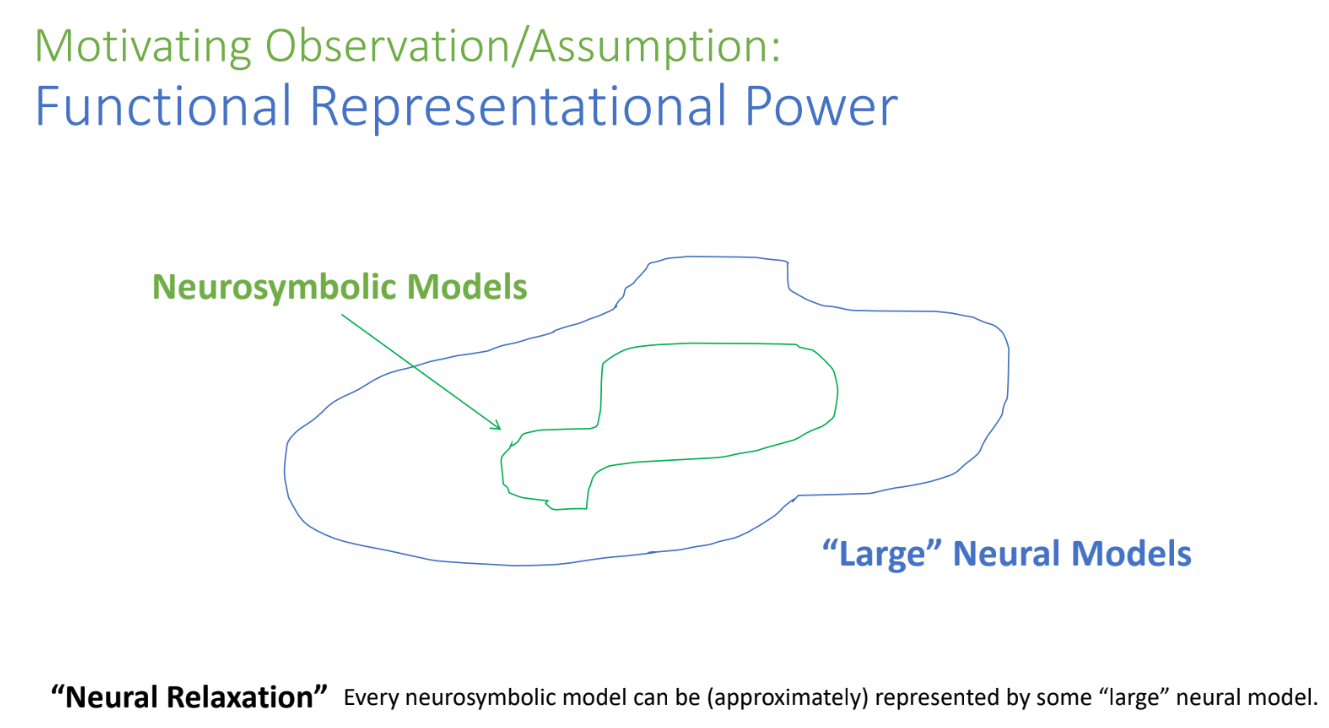

Run the utility code below to set up the training.

In [ ]:
!pip install pytorch-lightning # Pytorch lightning is a wrapper around PyTorch.
import os
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import f1_score, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 14.7 MB/s 
     |████████████████████████████████| 596 kB 58.8 MB/s 
     |████████████████████████████████| 140 kB 56.9 MB/s 
     |████████████████████████████████| 419 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 271 kB 76.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Utility Functions from Notebook 1

class TrainConfig:
    epochs: int = 20
    batch_size: int = 32
    lr: float = 3e-3
    weight_decay: float = 0.0
    train_size: int = 2000 # out of 5000
    val_size: int = 1000 # out of 5000
    test_size: int = 3000 # out of 3000
    num_classes: int = 2

config = TrainConfig()

# Dataloader for the CalMS21 dataset
class Calms21Task1Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, investigations_path, transform=None, target_transform=None):
        self.data = np.load(data_path)
        self.investigations = np.load(investigations_path)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.investigations[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


class Calms21Task1DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, target_transform=None ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_data_path = os.path.join(data_dir, "train_data.npy")
        self.train_investigations_path = os.path.join(data_dir, "train_investigation_labels.npy")
        self.test_data_path = os.path.join(data_dir, "test_data.npy")
        self.test_investigations_path = os.path.join(data_dir, "test_investigation_labels.npy")
        self.val_data_path = os.path.join(data_dir, "val_data.npy")
        self.val_investigations_path = os.path.join(data_dir, "val_investigation_labels.npy")
        self.transform = transform
        self.target_transform = target_transform

    def setup(self, stage=None):
        self.train_dataset = Calms21Task1Dataset(self.train_data_path, self.train_investigations_path, self.transform, self.target_transform)
        self.val_dataset = Calms21Task1Dataset(self.val_data_path, self.val_investigations_path, self.transform, self.target_transform)
        self.test_dataset = Calms21Task1Dataset(self.test_data_path, self.test_investigations_path, self.transform, self.target_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

dm = Calms21Task1DataModule(data_dir="data/calms21_task1/", batch_size=32, transform=None, target_transform=None)
dm.setup(None)

def train(model, datamodule, config):
    trainer = pl.Trainer(gpus=0, max_epochs=config.epochs)
    trainer.fit(model, datamodule)
    return model

# Evaluate using F1 score.
test_labels = np.load("data/calms21_task1/test_investigation_labels.npy")

def evaluate(model, data_loader, gt_labels):
  predictions = []
  for x,_ in data_loader:
    predictions.append(torch.argmax(model(x), dim = -1))

  predictions = torch.cat(predictions, dim = 0)

  f1 = f1_score(test_labels, predictions, average="binary")
  precision = precision_score(test_labels, predictions, average="binary")
  recall = recall_score(test_labels, predictions, average="binary")

  print("F1 score on test set: " + str(f1))
  print("Precision on test set: " + str(precision))
  print("Recall on test set: " + str(recall))

  return predictions, f1, precision, recall

**Exercise**: The cost of a program is represented by structural cost + the model performance (error in F1 score). Compare performance between: 

*    Program 1: `Window13Avg( Or(MinResNoseKeypointDistSelect,AccelerationSelect) )` 
*    Program 2: `Window13Avg( Or(AtomToAtomModule,AtomToAtomModule) )` 

Which program have lower cost in terms of error in F1 score? `AtomToAtomModule` from program 2 are neural networks, while `MinResNoseKeypointDistSelect` and `AccelerationSelect` from program 1 are feature selects with only a small set of weights and bias that are learned. Are you able to find features in `DSL_DICT` in `dsl.ipynb` that enables program 1 to perform better than program 2?

## Example of a symbolic program

In [ ]:
# Complete program
from dsl_compiler import ExpertProgram

program = "Window13Avg( Or(MinResNoseKeypointDistSelect,AccelerationSelect) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: /content/drive/MyDrive/Neurosymbolic_Summer_School_Tutorials/code_and_data/lightning_logs

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

F1 score on test set: 0.5983960518198643
Precision on test set: 0.5382907880133185
Recall on test set: 0.6736111111111112


## Example of a Neurosymbolic Program

How does the performance compare to the symbolic program above?

In [ ]:
# Neurosymbolic
program = "Window13Avg( Or(AtomToAtomModule,AtomToAtomModule) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

F1 score on test set: 0.7103977669225401
Precision on test set: 0.7138849929873773
Recall on test set: 0.7069444444444445


## Example of a Neural Module

How does the performance compare to the neurosymbolic program?

In [ ]:
# This is an RNN = basically fully neural. How does the error compare?
program = "ListToAtomModule"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

F1 score on test set: 0.7579843860894251
Precision on test set: 0.7750362844702468
Recall on test set: 0.7416666666666667


# NEAR: Astar Search

We can use NEAR as a heuristic to guide A* search. We maintain a frontier of nodes (starting with an empty program), and at each iteration we choose a node on the frontier to explore by using the NEAR heuristic with a structural cost to estimate its path cost. The search terminates when the frontier is empty, after which we return the best complete program found during our search.

## NEAR with Base DSL

How does the programs found by NEAR differ from enumeration through the search process? How does the frontier size change during the search process?

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_base \
--trial 1 \
--seed 1 \
--dsl_str "default" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Seed is 1
Experiment log and results saved at: results/investigation_base_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_and_data_4/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.5791 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.3788709677419355
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.562713567839196
Training child program: Start(Window5Avg(AtomToAtomModule))
DEBUG: f-score 0.9176923076923077
Frontier length is: 3
Total time elapsed is 9.5

## NEAR with Morlet DSL

How does the programs found by NEAR using the Morlet filter differ from enumeration through the search process? How does the program performance differ from the default DSL?

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"


Seed is 1
Experiment log and results saved at: results/investigation_morlet_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_and_data_4/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.5791 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.3788709677419355
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.562713567839196
Training child program: Start(MorletFilterOp(AtomToAtomModule))
DEBUG: f-score 0.5946560846560847
Frontier length is: 3
Total time elapsed 

# Visualizing Runtime vs. Accuracy 

To evaluate your NEAR runs, we can take the saved log files in `code_and_data/results` and plot the total runtime against accuracy.

**Optional Exercise**: Some hyperparameters that affect runtime and accuracy are listed below. Try changing a few of these and save a performance plot of your results.

*   `neural_epochs`: number of epochs to train the neural network approximator
*   `min_num_units` and `max_num_units`: minimum and maximum number of units in the neural network. The network is smaller as the search gets deeper.
*    `max_num_children`: max number of children for a node
*    `frontier_capacity`: capacity of frontier maintained by the search algorithm

How does the runtime and performance of NEAR compare to enumeration?

In [ ]:
# Plotting utility functions

def parse_runtime_f1_from_logs(log_files):

  runtime = []
  f1 = []

  runtime_key = 'Total time elapsed is'
  f1_key = 'F1 score achieved is'

  for item in log_files:
    # If there's a list of list of files corresponding to different random seeds,
    # we take the average
    if len(item[0]) > 1:
      seed_runtime = []
      seed_f1 = []
      for seed in item:
        with open(os.path.join('results', seed, 'log.txt')) as f:
            lines = f.readlines()

            curr_runtimes = []
            for line in lines:
              if runtime_key in line:
                if line.split(runtime_key)[-1].startswith(':'):
                  curr_runtimes.append(float(line.split(runtime_key)[-1].strip()[1:]))
                else:
                  curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
            
              if f1_key in line:
                seed_f1.append(float(line.split(f1_key)[-1].strip()))
            seed_runtime.append(curr_runtimes[-1])
      runtime.append(np.mean(seed_runtime))
      f1.append(np.mean(seed_f1))        
    else:
      # There's only 1 seed per run
      with open(os.path.join('results', item, 'log.txt')) as f:
        lines = f.readlines()

      curr_runtimes = []
      for line in lines:
        if runtime_key in line:
            if line.split(runtime_key)[-1].startswith(':'):
              curr_runtimes.append(float(line.split(runtime_key)[-1].strip()[1:]))
            else:
              curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
      
        if f1_key in line:
          f1.append(float(line.split(f1_key)[-1].strip()))
      runtime.append(curr_runtimes[-1])

  return runtime, f1

def plot_runtime_f1(runtime, f1, labels):
  assert(len(runtime) == len(f1) == len(labels))

  fig = plt.figure()
  for i, item in enumerate(labels):
    if len(item[0]) > 1:
      item = item[0]
    plt.scatter(runtime[i], f1[i], label = item.split('_sd')[0])

  plt.xlim([10, 400])
  plt.ylim([0.3, 0.75])  
  plt.xlabel("Runtime (s)")
  plt.ylabel("F1 score")    
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1 + 0.1*len(labels)))


investigation_base_enumeration_sd_1_001
investigation_morlet_enumeration_sd_1_001
investigation_base_astar-near_sd_1_001
investigation_morlet_astar-near_sd_1_001


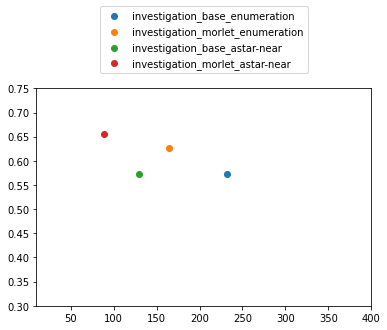

In [ ]:
# Directory names to plot inside near_code/results
run_names_to_plot = ['investigation_base_enumeration_sd_1_001', 
                     'investigation_morlet_enumeration_sd_1_001',
                     'investigation_base_astar-near_sd_1_001',
                     'investigation_morlet_astar-near_sd_1_001']

runtime, f1 = parse_runtime_f1_from_logs(run_names_to_plot)

plot_runtime_f1(runtime, f1, run_names_to_plot)

# [Optional] Open-Ended Exploration

Can you improve the performance of neurally-guided program search? Submit your runs on seed 1 (default) to [https://forms.gle/peEi6vryaJQejTcn9](https://forms.gle/peEi6vryaJQejTcn9). Feel free to make any changes to the code! Below are some suggestions:

*   Modifying neural heuristic: looking at the neural modules in `dsl.ipynb`, such as `ListToAtomModule` or `AtomToAtomModule` and the hyperparameters for training the neural approximators, are you able to improve the neural heuristic we currently use? The ideal neural heuristic would be able to be trained quickly, while approximating the program performance closely and is admissible. 
*   Modify search space: are there any modifications you can make to the search space, for example, through modifying the DSL or min/max program depth that leads to better runtime and performance?

# [Optional] Modify Architecture of AtomToAtom Heuristic

In `dsl.ipynb`, the architecture of the neural heuristics used are defined in the Section called Neural Functions. In this section, the `AtomToAtomModule` in `dsl.ipynb` uses a 2-layer network in `FeedForwardModule` as the neural approximator. Modify the network architecture to add a third layer and run NEAR below. Do you observe any changes in performance? Why or why not?

**Important**: after modifying `dsl.ipynb`, you will need to re-convert your new dsl to python files, included in the cell below.


In [ ]:
!jupyter nbconvert --to python dsl.ipynb
!jupyter nbconvert --to python near.ipynb

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet_3layer \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 16 \
--min_num_units 8 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_3layer_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_sketch/near_code/near.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.1141 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.7521428571428572
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.9096103896103896
Training child program: Start(MorletFilterOp(AtomToAtomMod

# [Optional] NEAR: IDDFS Search - Morlet DSL

The admissible heuristics used by NEAR is compatible with different search strategies - here, we use [iterative deepening depth-first search](https://en.wikipedia.org/wiki/Iterative_deepening_depth-first_search) (IDDFS) instead of A* search through the program space. IDDFS is a search strategy where depth-limited version of depth-first search is run repreatedly with increasing depth limits.

How does the performance of IDDFS compare to A* on this dataset?


In [ ]:
!yes| python train.py \
--algorithm iddfs-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 5 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 16 \
--min_num_units 8 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_iddfs-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_sketch/near_code/near.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. Score from program is 0.1141 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Frontier length is: 0
Frontier length is now 0
Empty frontier, moving to next depth level
DEBUG: time since start is 8.520

Starting iterative deepening with depth 2

CURRENT program has depth 1, fscore 0.4796: Start(MorletFilterOp(AtomToAtomModule))
New BEST program found:
St

# [Optional] Additional Experiments: Test on Other Behavior Classes

In behavior analysis, animals exhibit a wide range of behaviors, and the goal of behavioral neuroscience is to learn the neural basis of these behaviors. Investigation vs. no investigation is one example of a human-defined behavior, but there's also behaviors such as mount, attack, rearing, approach, groom, ...

Here, we provide an additional set of behavior annotations for mount. How does the DSL and algorithm you developed compare to using enumeration as a baseline for program search? Mount is a relatively rare class compared to investigation - how do the performances compare?

In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_mount_labels.npy" \
--test_labels "data/calms21_task1/test_mount_labels.npy" \
--valid_labels "data/calms21_task1/val_mount_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 648 programs found
Symbolic Synthesis: generated 648/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(MorletFilterOp(ResAngleHeadBodySelect()))
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_sketch/near_code/near.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggere

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_mount_labels.npy" \
--test_labels "data/calms21_task1/test_mount_labels.npy" \
--valid_labels "data/calms21_task1/val_mount_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"


Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_sketch/near_code/near.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.3256 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.6866666666666668
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.6376470588235293
Training child program: Start(MorletFilterOp(AtomToAtomModule))
D

**Acknowledgements**: This notebook was developed by Jennifer J. Sun  (Caltech) and Atharva Sengal (UT Austin) for [the neurosymbolic summer school](http://www.neurosymbolic.org/summerschool.html). The data subset is processed from CalMS21 and the DSL is developed by by Megan Tjandrasuwita (MIT) from her work on [Interpreting Expert Annotation Differences in Animal Behavior](https://arxiv.org/pdf/2106.06114.pdf). Megan's work is partly based on [NEAR](https://github.com/trishullab/near/tree/master/near_code) by Ameesh Shah (Berkeley) and Eric Zhan (Argo).